In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import datetime
import pytz
import matplotlib.pyplot as plt
from collections import Counter
from pandas import Series, DataFrame
import seaborn as sns

import hatching as ht
from scipy import stats

import igraph as ig
import networkx as nx
import graph_tool as gt

In [ ]:
f = 'TT1_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-14 08:00:00+00:00.graphml'
f = 'TT2_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-17 08:00:00+00:00.graphml'
nxg = nx.read_graphml(f)

In [ ]:
print(nx.info(nxg))

In [ ]:
igg = ig.Graph.Read_GraphML(f)

In [ ]:
igg.summary()

In [ ]:
gtg = gt.load_graph(f)

In [ ]:
gtg

# iGraph Algos

## :) Fastgreedy

In [ ]:
fg = igg.community_fastgreedy(weights="frequency")

In [ ]:
vc = fg.as_clustering(fg.optimal_count)
print(vc.summary())

In [ ]:
ids = []
membership = vc.membership
for name, membership in zip(igg.vs, membership):
    ids.append((int(name['id']), membership))

ids = DataFrame(ids, columns=["id", "community"])
ids.groupby(by="community").size()

## Infomap

In [ ]:
im = igg.community_infomap(edge_weights="frequency")

In [ ]:
im.summary()

## :) leading_eigenvector

In [ ]:
lev = igg.community_leading_eigenvector(weights="frequency")

In [ ]:
lev.summary()

In [ ]:
def getMembershipDF(stuff, g):
    ids = []
    membership = stuff.membership
    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))

    ids = DataFrame(ids, columns=["id", "community"])
    print(ids.groupby(by="community").size())
    print(ids.groupby(by="community").size().sum())

In [ ]:
getMembershipDF(lev, igg)

## Label Propagation

In [ ]:
lpg = igg.community_label_propagation(weights="frequency")

In [ ]:
lpg.summary()

## :) Multilevel

In [ ]:
ml = igg.community_multilevel(weights="frequency")

In [ ]:
ml.summary()

In [ ]:
getMembershipDF(ml, igg)

## Spinglass

In [ ]:
#sg = igg.community_spinglass(weights="frequency")

In [ ]:
#sg.summary()

In [ ]:
#getMembershipDF(sg, igg)

## :) Walktrap

In [ ]:
wt = igg.community_walktrap(weights="frequency", 0)

In [ ]:
wtvc = wt.as_clustering(wt.optimal_count)
print(wtvc.summary())

In [ ]:
ids = []
membership = wtvc.membership
for name, membership in zip(igg.vs, membership):
    ids.append((int(name['id']), membership))

ids = DataFrame(ids, columns=["id", "community"])
ids.groupby(by="community").size()

# Graph-tools

In [ ]:
gtg

In [ ]:
from graph_tool.all import *

In [ ]:
gt.inference.minimize_blockmodel_dl()

# networkX - community package

In [ ]:
import pythonlouvain.community.community_louvain as community

In [ ]:
partition = community.best_partition(nxg, weight="frequency")

In [ ]:
df = DataFrame(list(zip(list(partition.keys()),list(partition.values()))), columns=["id", "comm"])

In [ ]:
df.groupby(by="comm").size()

# Compare Comunity Outcome

In [18]:
def addAge(df, date_dt):
    aa = ht.get_all_bees_age(date_dt)
    df["age"] = df.id.apply(lambda x: aa.iloc[x].age)
    return df

In [42]:
def compareCommunities(g, datestr):
    fg = g.community_fastgreedy(weights="frequency")
    fgvc = fg.as_clustering(fg.optimal_count)

    ids = []
    membership = fgvc.membership
    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))

    ids = DataFrame(ids, columns=["id", "community-fg"])
    
    lev = g.community_leading_eigenvector(weights="frequency")
    ids['community-le'] = lev.membership
    
    ml = g.community_multilevel(weights="frequency")
    ids['community-ml'] = ml.membership
    
    wt = g.community_walktrap(weights="frequency", steps=3)
    wtvc = wt.as_clustering(wt.optimal_count)
    ids['community-wt'] = wtvc.membership
    
    start_dt = datetime.datetime.strptime(datestr, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
    ids = addAge(ids, start_dt)

    return ids

In [ ]:
dfc = compareCommunities(igg)

In [ ]:
start = "2016-08-14"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%d").replace(tzinfo=pytz.UTC)

In [ ]:
dfc = addAge(dfc, start_dt)

In [ ]:
dfc.head()

In [23]:
def commSize(df, col):
    print(df.groupby(by=col).size())

In [24]:
def commMeanAge(df, col):
    print(df.groupby(by=col).age.mean())

## Size and Number

In [ ]:
commSize(df, 'community-fg'), commSize(df, 'community-le'), commSize(df, 'community-ml'),commSize(df, 'community-wt')

## Mean Age

In [ ]:
commMeanAge(df, 'community-fg'), commMeanAge(df, 'community-le'), commMeanAge(df, 'community-ml'),commMeanAge(df, 'community-wt')

## Look at IDs

In [26]:
def getIdList(df, col):
    return df.groupby(by=col).id.apply(set)

In [ ]:
getIdList(dfc, 'community-fg')

In [6]:
def overlap1(s0, s1):
    x = len(set(s0).intersection(s1))
    y = len(set(s0).union(s1))
    return x/y

In [7]:
def getMappingScore(df, col1, col2):
    id1 = getIdList(df, col1)
    id2 = getIdList(df, col2)
    
    print(col1, commSize(df, col1), col2, commSize(df,col2))
    
    for e1, i in enumerate(id1):
        for e2, j in enumerate(id2):
            print(e1, col1, e2, col2, overlap1(i,j))
        print('\n')

In [ ]:
getMappingScore(dfc, 'community-fg', 'community-le')

In [ ]:
getMappingScore(dfc, 'community-le', 'community-ml')

In [ ]:
getMappingScore(dfc, 'community-le', 'community-wt')

In [ ]:
getMappingScore(dfc, 'community-ml', 'community-wt')

In [28]:
def alles(df):
    print(commSize(df, 'community-fg'), commSize(df, 'community-le'), commSize(df, 'community-ml'),commSize(df, 'community-wt'))
    print(commMeanAge(df, 'community-fg'), commMeanAge(df, 'community-le'), commMeanAge(df, 'community-ml'),commMeanAge(df, 'community-wt'))
    print(getMappingScore(df, 'community-fg', 'community-le'))
    print(getMappingScore(df, 'community-fg', 'community-ml'))
    print(getMappingScore(df, 'community-fg', 'community-wt'))
    print(getMappingScore(df, 'community-le', 'community-ml'))
    print(getMappingScore(df, 'community-le', 'community-wt'))
    print(getMappingScore(df, 'community-ml', 'community-wt'))

In [59]:
def thresholdedGraph(file, border):

    G = nx.read_graphml(file)
    print(nx.info(G))
    
    lowedges = []
    for a,b in list(G.edges()):
        data = G.get_edge_data(a,b)
        f = data.get('frequency')
        if f <= border:
            lowedges.append((a,b))

    print("anzahl removed edges", len(lowedges))
    for e in lowedges:
        G.remove_edge(e[0],e[1])

    print(nx.info(G))

    Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    print("Number of components: {}".format(len(Gcc)))

    size_components = []
    for comp in Gcc:
        size_components.append(nx.number_of_nodes(comp))
    
    print(Counter(list(size_components)))

    G = Gcc[0]

    nx.write_graphml(G, 'ttt.graphml')
    
    return ig.Graph.Read_GraphML('ttt.graphml')

In [ ]:
alles(dfc)

# Alle Testen Stat

In [457]:
f1 = 'TT1_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-14_08:00:00+00:00.graphml'
f2 = 'TT2_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-17_08:00:00+00:00.graphml'
f3 = 'TT3_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-20_08:00:00+00:00.graphml'
#f4 = 'TT4_10h_95conf_212dist_4ilen_2gap_600minutes_2016-09-02 08:00:00+00:00.graphml'

In [459]:
f1 = 'TT1_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-14 08:00:00+00:00.graphml'
f2 = 'TT2_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-17 08:00:00+00:00.graphml'
f3 = 'TT3_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-20 08:00:00+00:00.graphml'

In [460]:
g1 = ig.Graph.Read_GraphML(f1)
g2 = ig.Graph.Read_GraphML(f2)
g3 = ig.Graph.Read_GraphML(f3)
#g4 = ig.Graph.Read_GraphML(f4)

In [81]:
#g1 = thresholdedGraph(f1, 1)
#g2 = thresholdedGraph(f2, 1)
#g3 = thresholdedGraph(f3, 1)
#g4 = thresholdedGraph(f4, 1)

In [461]:
g1.summary(), g2.summary(), g3.summary(), g4.summary()

('IGRAPH U--- 1193 406023 -- \n+ attr: id (v), frequency (e), totalduration (e)',
 'IGRAPH U--- 1095 381548 -- \n+ attr: id (v), frequency (e), totalduration (e)',
 'IGRAPH U--- 922 291179 -- \n+ attr: id (v), frequency (e), totalduration (e)',
 'IGRAPH U--- 378 37554 -- \n+ attr: id (v), frequency (e), totalduration (e)')

In [88]:
g1.summary(), g2.summary(), g3.summary(), g4.summary()

('IGRAPH U--- 1193 379370 -- \n+ attr: id (v), frequency (e), totalduration (e)',
 'IGRAPH U--- 1095 357936 -- \n+ attr: id (v), frequency (e), totalduration (e)',
 'IGRAPH U--- 921 276048 -- \n+ attr: id (v), frequency (e), totalduration (e)',
 'IGRAPH U--- 378 37554 -- \n+ attr: id (v), frequency (e), totalduration (e)')

In [462]:
t1 = compareCommunities(g1, "2016-08-14")

In [463]:
t2 = compareCommunities(g2, "2016-08-17")

In [490]:
t3 = compareCommunities(g3, "2016-08-20")

In [69]:
#t4 = compareCommunities(g4, "2016-09-02")

In [465]:
alles(t1)

community-fg
0    359
1    834
dtype: int64
community-le
0    354
1    502
2    337
dtype: int64
community-ml
0    313
1    541
2    339
dtype: int64
community-wt
0    245
1    471
2    476
3      1
dtype: int64
None None None None
community-fg
0     8.359331
1    21.575540
Name: age, dtype: float64
community-le
0     8.257062
1    24.205179
2    17.569733
Name: age, dtype: float64
community-ml
0     6.706070
1    24.048059
2    17.362832
Name: age, dtype: float64
community-wt
0     5.624490
1    24.407643
2    17.010504
3    24.000000
Name: age, dtype: float64
None None None None
community-fg
0    359
1    834
dtype: int64
community-le
0    354
1    502
2    337
dtype: int64
community-fg None community-le None
0 community-fg 0 community-le 0.9322493224932249
0 community-fg 1 community-le 0.0011627906976744186
0 community-fg 2 community-le 0.020527859237536656


1 community-fg 0 community-le 0.008488964346349746
1 community-fg 1 community-le 0.6
1 community-fg 2 community-le 0.38089622

In [466]:
alles(t2)

community-fg
0    604
1    458
2     33
dtype: int64
community-le
0    639
1    456
dtype: int64
community-ml
0    554
1    536
2      5
dtype: int64
community-wt
0    604
1    491
dtype: int64
None None None None
community-fg
0    23.966887
1    11.661572
2    19.060606
Name: age, dtype: float64
community-le
0    23.615023
1    11.745614
Name: age, dtype: float64
community-ml
0    24.368231
1    12.718284
2    25.800000
Name: age, dtype: float64
community-wt
0    23.859272
1    12.291242
Name: age, dtype: float64
None None None None
community-fg
0    604
1    458
2     33
dtype: int64
community-le
0    639
1    456
dtype: int64
community-fg None community-le None
0 community-fg 0 community-le 0.9421875
0 community-fg 1 community-le 0.0009442870632672333


1 community-fg 0 community-le 0.00919963201471941
1 community-fg 1 community-le 0.9613733905579399


2 community-fg 0 community-le 0.04024767801857585
2 community-fg 1 community-le 0.014522821576763486


None
community-fg
0    604
1 

In [467]:
alles(t3)

community-fg
0    434
1    473
2     15
dtype: int64
community-le
0    434
1    488
dtype: int64
community-ml
0    465
1    431
2     26
dtype: int64
community-wt
0    472
1    449
2      1
dtype: int64
None None None None
community-fg
0    16.824885
1    25.014799
2    28.866667
Name: age, dtype: float64
community-le
0    16.806452
1    25.149590
Name: age, dtype: float64
community-ml
0    25.040860
1    16.791183
2    26.384615
Name: age, dtype: float64
community-wt
0    17.567797
1    25.069042
2    19.000000
Name: age, dtype: float64
None None None None
community-fg
0    434
1    473
2     15
dtype: int64
community-le
0    434
1    488
dtype: int64
community-fg None community-le None
0 community-fg 0 community-le 0.9772209567198178
0 community-fg 1 community-le 0.0054525627044711015


1 community-fg 0 community-le 0.00331858407079646
1 community-fg 1 community-le 0.9572301425661914


2 community-fg 0 community-le 0.0044742729306487695
2 community-fg 1 community-le 0.026530612244897

In [444]:
t2[t2["community-fg"] == 0].head()

,id,community-fg,community-le,community-ml,community-wt,age
0,6,0,0,0,0,29
1,27,0,0,0,0,42
2,36,0,0,0,0,35
3,60,0,0,0,0,36
4,116,0,0,0,0,35


# Plotten

In [96]:
import sqlite3

In [97]:
db_path = "/mnt/data/2016_08_14_10h_8Uhr_95conf.db"
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [99]:
def getDFwithIDSts(ids, begin, end, conn):
    ids_str = ', '.join([str(x) for x in ids])
    sql = '''
        SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
        FROM DETECTIONS d
        INNER JOIN FRAME f
        ON d.FRAME_ID=f.FRAME_ID
        INNER JOIN FRAME_CONTAINER fc
        ON f.FC_ID=fc.FC_ID
        WHERE d.ID IN ({}) AND
        f.TIMESTAMP >= {} AND
        f.TIMESTAMP <= {};
    '''.format(ids_str, begin,end)
    return pd.read_sql(sql, conn)

In [100]:
start_dt = datetime.datetime.strptime("2016-08-14T08:00:00Z", "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)

end_dt = datetime.datetime.strptime("2016-08-14T18:00:00Z", "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)

In [178]:
end_dt.timestamp()

1471197600.0

In [103]:
start_dt.timestamp()

1471161600.0

In [104]:
df1 = getDFwithIDSts([2055], start_dt.timestamp(), end_dt.timestamp(), conn)

In [105]:
df1.head()

,XPOS,YPOS,ID,CAM_ID
0,588,2036,2055,1
1,588,2024,2055,1
2,588,2024,2055,1
3,589,2049,2055,1
4,576,2061,2055,1


In [161]:
def plotHeatmapXY(txt, df, camid):
    
    data = df[df.CAM_ID == camid]
    
    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("ticks")


    sns.lmplot('XPOS', 'YPOS',
               data=data,
               fit_reg=False,  
               scatter_kws={"marker": "D",
                            "s": 2,
                            "alpha" : 0.5})
    plt.title(camid)
    plt.xlabel('x')
    plt.ylabel('y')

In [192]:
def getBinnedData(ids, begin, end, conn, camid, xbins, ybins):
    
    sizeX = int(3000/xbins)
    sizeY = int(4000/ybins)
    
    ids_str = ', '.join([str(x) for x in ids])
    sql = '''
        SELECT tab.XBIN as xbin, tab.YBIN as ybin, COUNT(*) as count
        FROM (
          SELECT
            d.XPOS / {} as XBIN,
            d.YPOS / {} as YBIN,
            d.ID,
            fc.CAM_ID
          FROM DETECTIONS d
            INNER JOIN FRAME f
              ON d.FRAME_ID = f.FRAME_ID
            INNER JOIN FRAME_CONTAINER fc
              ON f.FC_ID = fc.FC_ID
          WHERE
            d.ID IN ({}) AND
            fc.CAM_ID == {} AND
            f.TIMESTAMP >= {} AND
            f.TIMESTAMP <= {}
        ) tab
        GROUP BY tab.XBIN, tab.YBIN
        ;
    '''.format(sizeX, sizeY, ids_str, camid, begin, end)
    return pd.read_sql(sql, conn)

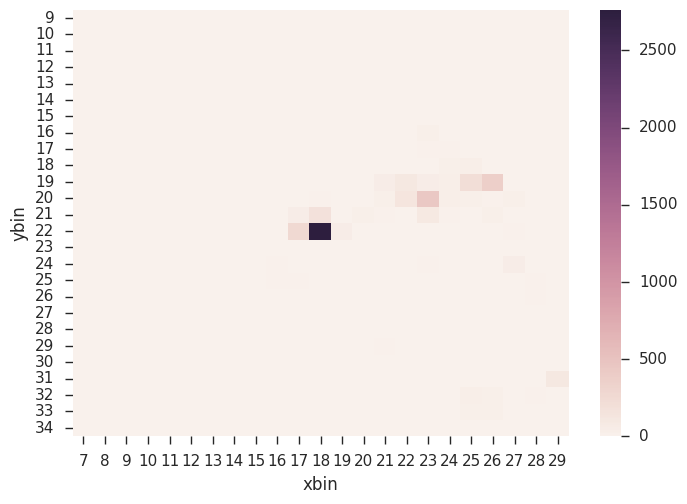

In [226]:
df1 = getBinnedData([2055], start_dt.timestamp(), end_dt.timestamp(), conn, 0, 30, 40)

data = df1.pivot("ybin", "xbin", "count").fillna(0)

sns.heatmap(data, )

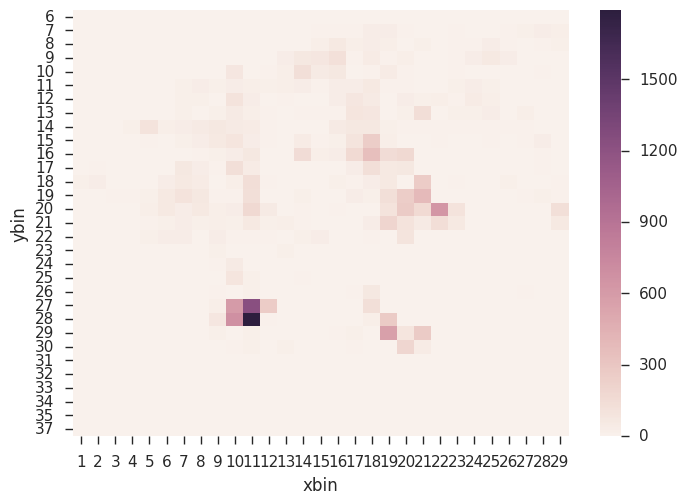

In [227]:
df1 = getBinnedData([2055], start_dt.timestamp(), end_dt.timestamp(), conn, 1, 30, 40)

data = df1.pivot("ybin", "xbin", "count").fillna(0)

sns.heatmap(data, )

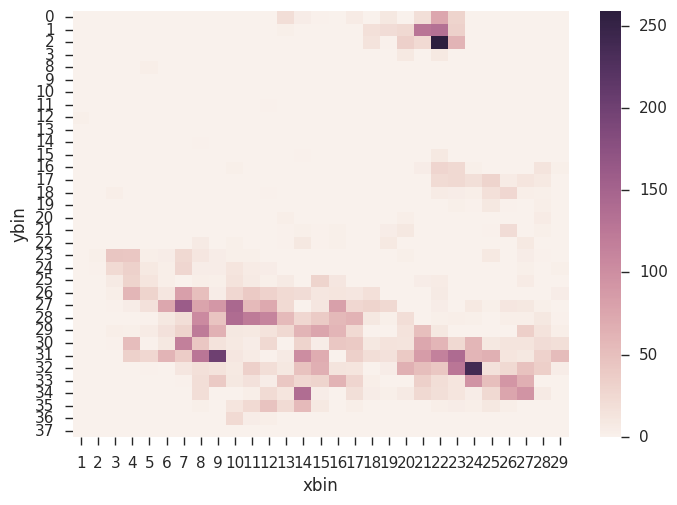

In [228]:
df1 = getBinnedData([2055], start_dt.timestamp(), end_dt.timestamp(), conn, 2, 30, 40)

data = df1.pivot("ybin", "xbin", "count").fillna(0)

sns.heatmap(data, )

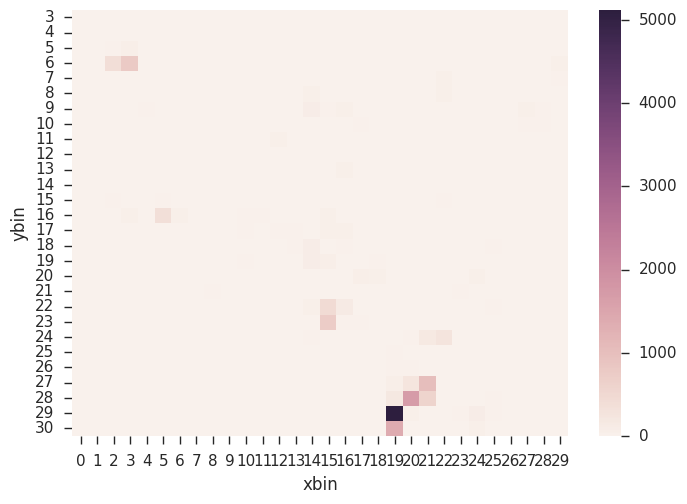

In [230]:
df1 = getBinnedData([2055], start_dt.timestamp(), end_dt.timestamp(), conn, 3, 30, 40)

data = df1.pivot("ybin", "xbin", "count").fillna(0)

sns.heatmap(data, )

# Plotten einer ganzen Community eines Tages

In [296]:
sns.set_context("paper")

In [445]:
def plotHeatmap(liste, xbins, ybins, txt, datestring, path):
    conn = sqlite3.connect(path)
    
    #liste = liste[:3]
    s = datetime.datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
    e = s + datetime.timedelta(hours=10)
    
    datas = np.empty(4, dtype=object)
    maxes = []
    summ = 0
    for i in [0,1,2,3]:
        df = getBinnedData(liste, s.timestamp(), e.timestamp(), conn, i, xbins, ybins)
        data = df.pivot("ybin", "xbin", "count").fillna(0)
        summ += data.sum().sum()
        
        maxes.append(data.max().max())
        datas[i] = data
        print((data.shape))
    
    vmax = max(maxes)/summ

    
    fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
    plt.suptitle("{}\n n={}".format(txt, len(liste)))
    
    for i, ax in enumerate(axn.flat):
        datas[i] = datas[i]/summ
        # spiegeln horizontal und vertikal
        if (i in [1,3]):
            datas[i] = datas[i][datas[i].columns[::-1]]
            datas[i] = datas[i].iloc[::-1]
        
        sns.heatmap(datas[i],
                    ax=ax,
                    cbar=i == 0,
                    xticklabels=False,
                    yticklabels=False,
                    vmin=0,
                    vmax=vmax,
                    cbar_ax=None if i else cbar_ax)
        
        ax.set_xlabel("")
        ax.set_ylabel("")
        
        ax.set_aspect('equal')
        ax.set_title("Camera {}".format(i))
        
    fig.set_size_inches(5.91553,4)
    fig.tight_layout()
    plt.savefig('{}-{}-{}.pdf'.format(txt, len(liste), datestring))
    plt.show()

    return datas

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


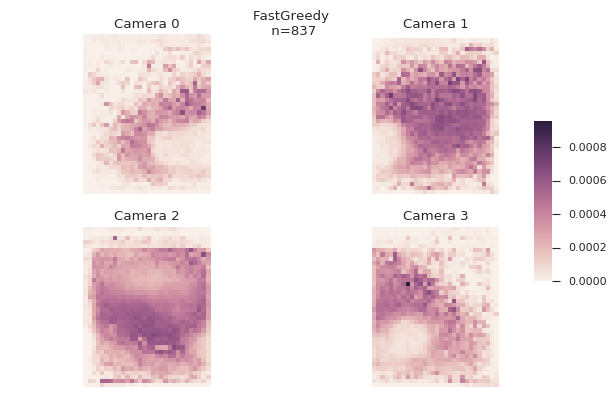

(38, 30)
(37, 30)
(39, 30)
(38, 30)


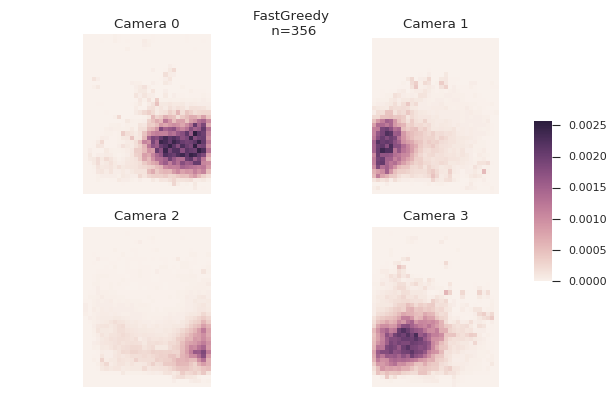

StopIteration: 

In [421]:
t1.groupby(by="community-fg").id.apply(list).apply(plotHeatmap, args=[30,40, "FastGreedy", "2016-08-14T08:00:00Z"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


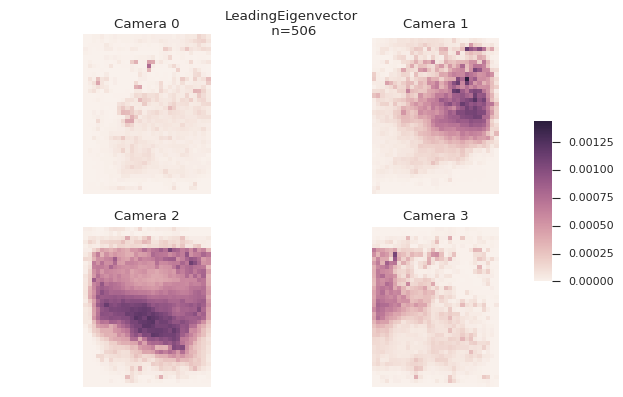

(38, 30)
(37, 30)
(39, 30)
(38, 30)


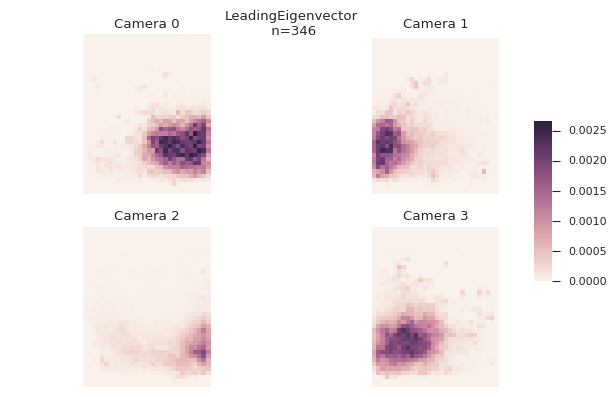

(38, 30)
(37, 30)
(39, 30)
(38, 30)


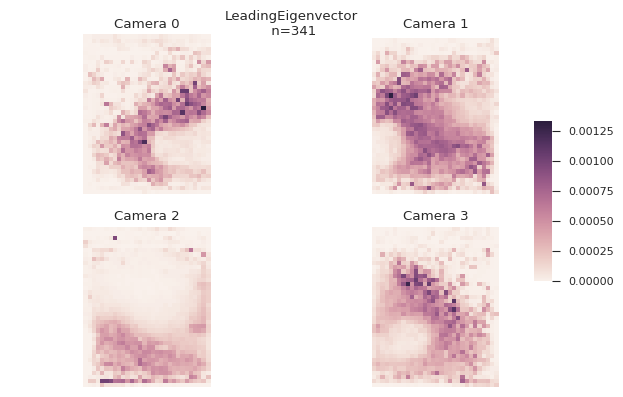

StopIteration: 

In [422]:
t1.groupby(by="community-le").id.apply(list).apply(plotHeatmap, args=[30,40, "LeadingEigenvector", "2016-08-14T08:00:00Z"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


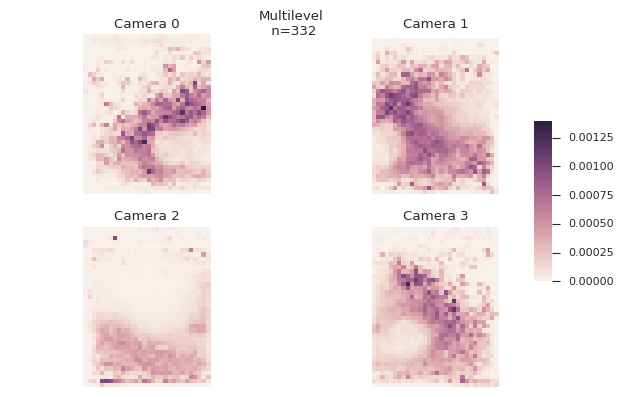

(38, 30)
(37, 30)
(39, 30)
(38, 30)


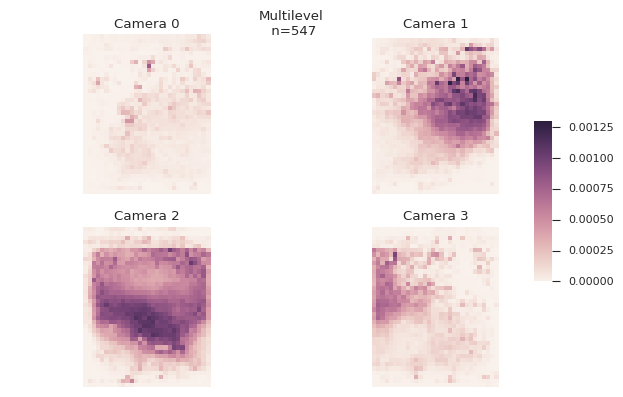

(38, 30)
(37, 30)
(39, 30)
(38, 30)


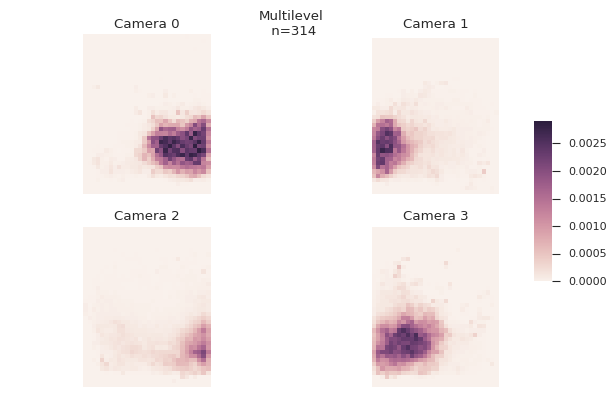

StopIteration: 

In [423]:
t1.groupby(by="community-ml").id.apply(list).apply(plotHeatmap, args=[30,40, "Multilevel", "2016-08-14T08:00:00Z"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


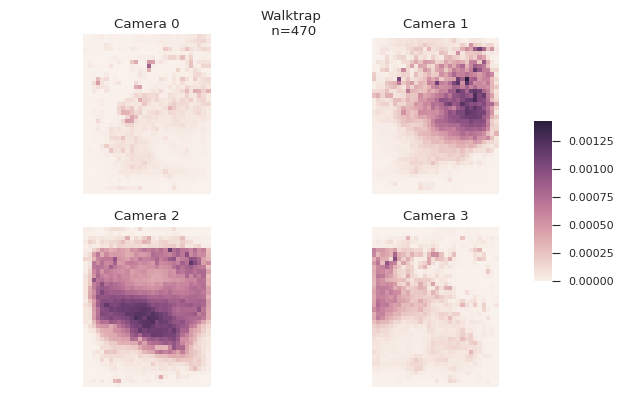

(38, 30)
(37, 30)
(39, 30)
(38, 30)


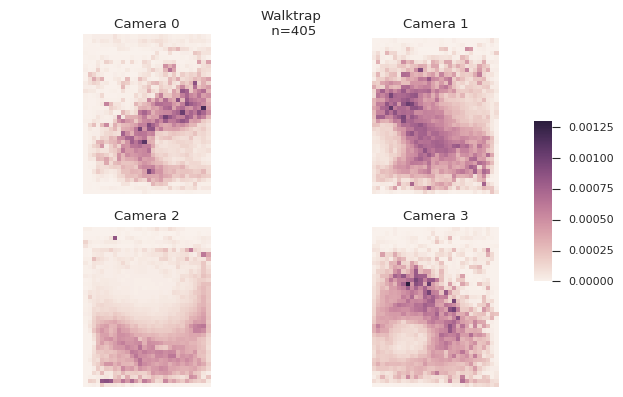

(38, 30)
(37, 30)
(39, 30)
(38, 30)


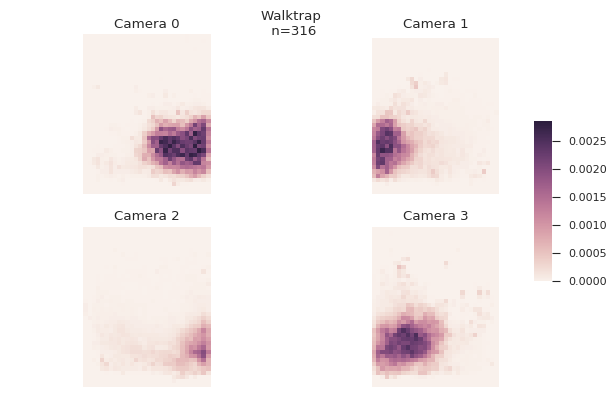

(7, 4)
(11, 9)
(30, 27)
(18, 16)


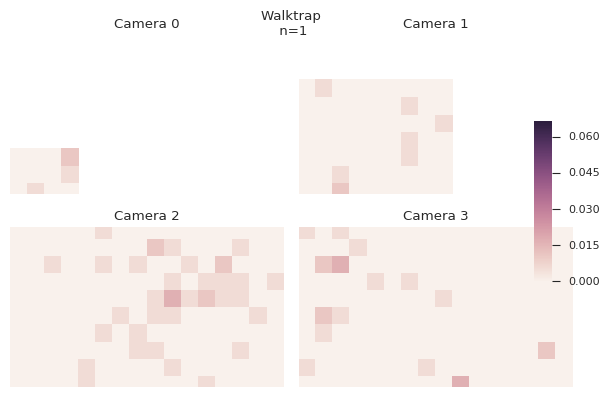

(4, 6)
(6, 7)
(3, 3)
(9, 11)


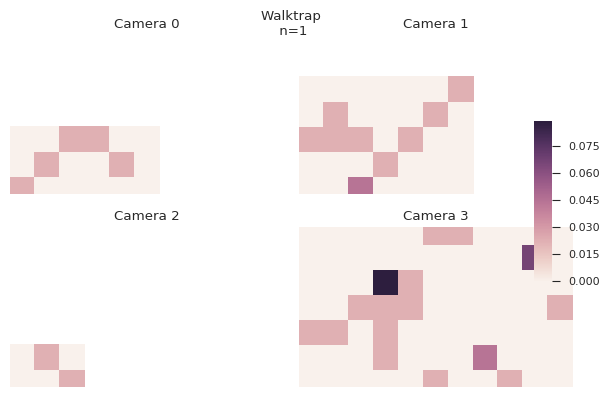

StopIteration: 

In [424]:
t1.groupby(by="community-wt").id.apply(list).apply(plotHeatmap, args=[30,40, "Walktrap", "2016-08-14T08:00:00Z"])

In [434]:
t2.head()

,id,community-fg,community-le,community-ml,community-wt,age
0,6,0,0,0,0,29
1,27,0,0,0,0,42
2,36,0,0,0,0,35
3,60,0,0,0,0,36
4,116,0,0,0,0,35


(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


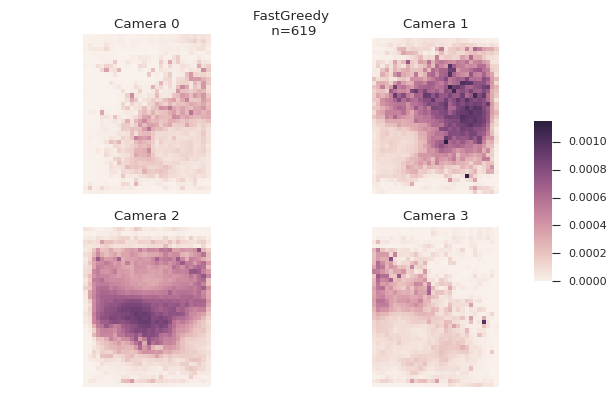

(38, 30)
(37, 30)
(39, 30)
(38, 30)


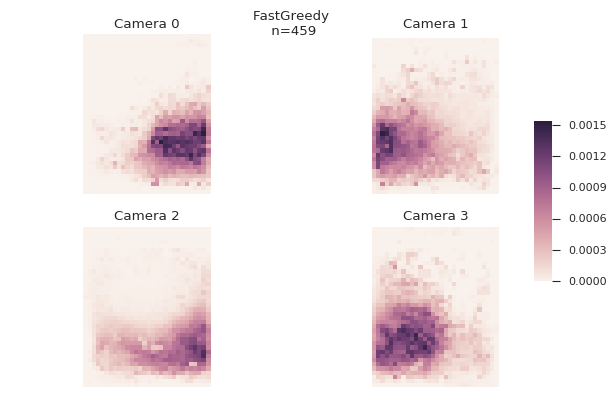

(38, 30)
(37, 30)
(39, 30)
(38, 30)


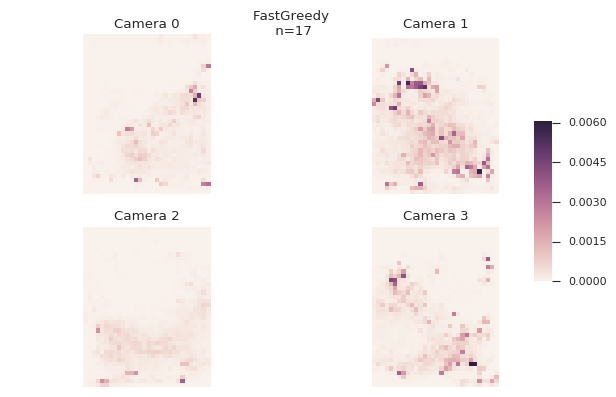

StopIteration: 

In [446]:
t2.groupby(by="community-fg").id.apply(list).apply(plotHeatmap, args=[30,40, "FastGreedy", "2016-08-17T08:00:00Z", "/mnt/data/2016_08_17_10h_8Uhr_95conf.db"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


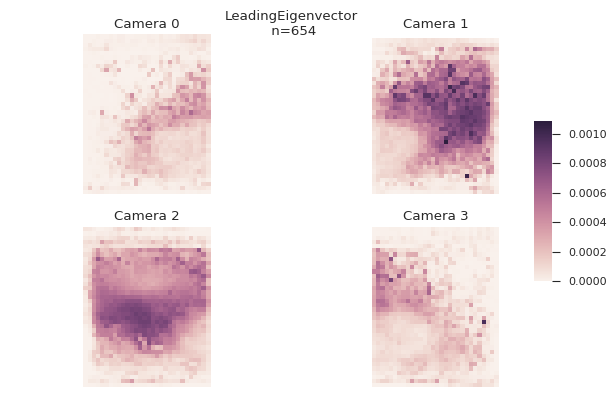

(38, 30)
(37, 30)
(39, 30)
(38, 30)


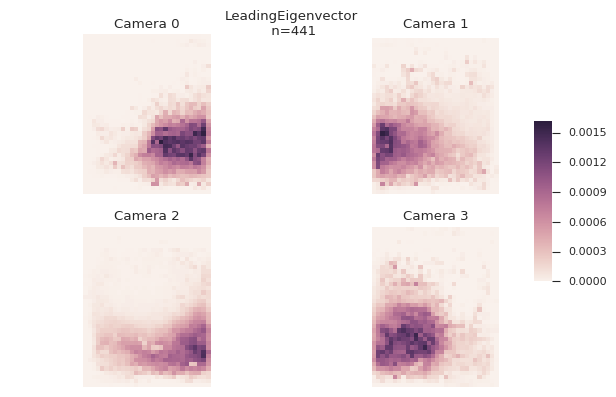

StopIteration: 

In [447]:
t2.groupby(by="community-le").id.apply(list).apply(plotHeatmap, args=[30,40, "LeadingEigenvector", "2016-08-17T08:00:00Z", "/mnt/data/2016_08_17_10h_8Uhr_95conf.db"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


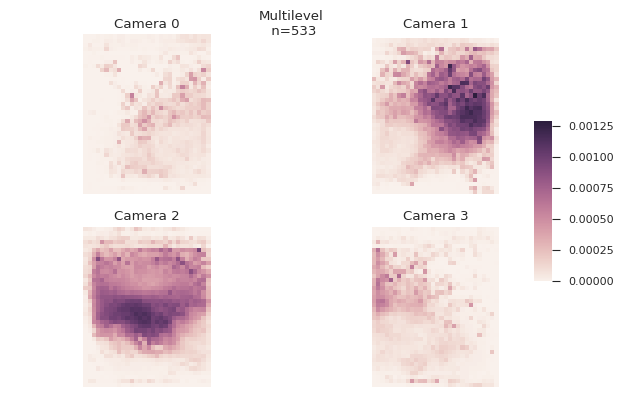

(38, 30)
(37, 30)
(39, 30)
(38, 30)


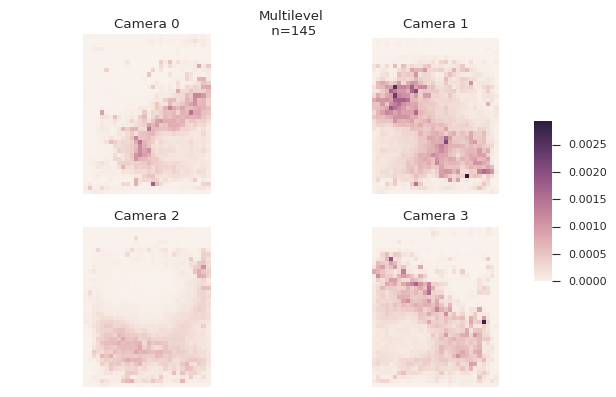

(38, 30)
(37, 30)
(39, 30)
(38, 30)


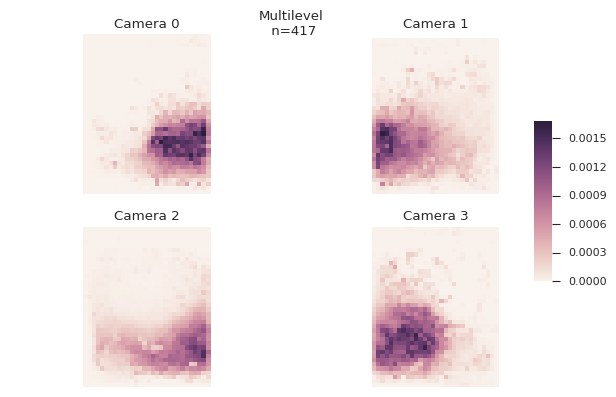

StopIteration: 

In [449]:
t2.groupby(by="community-ml").id.apply(list).apply(plotHeatmap, args=[30,40, "Multilevel", "2016-08-17T08:00:00Z", "/mnt/data/2016_08_17_10h_8Uhr_95conf.db"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


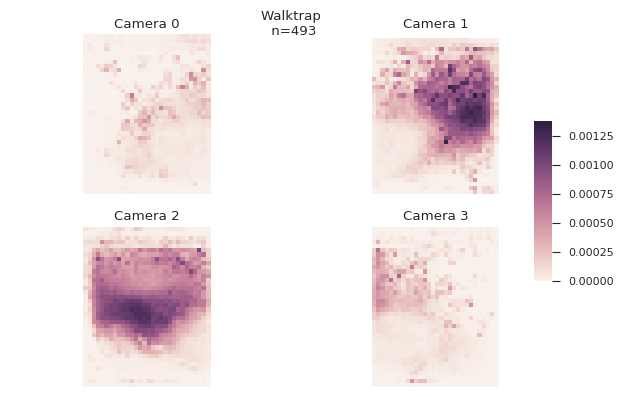

(38, 30)
(37, 30)
(39, 30)
(38, 30)


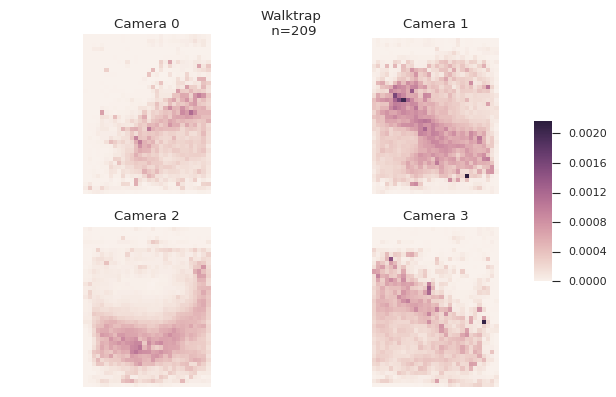

(38, 30)
(37, 30)
(39, 30)
(38, 30)


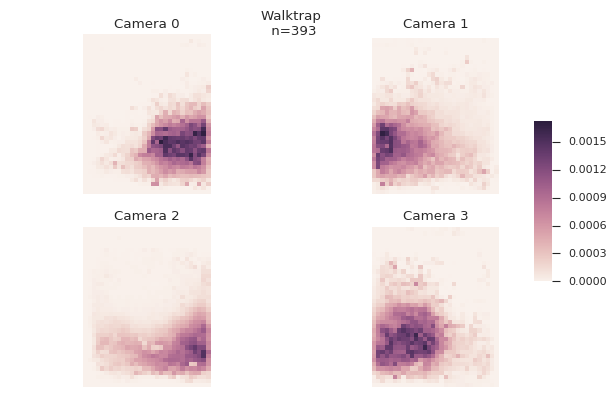

StopIteration: 

In [450]:
t2.groupby(by="community-wt").id.apply(list).apply(plotHeatmap, args=[30,40, "Walktrap", "2016-08-17T08:00:00Z", "/mnt/data/2016_08_17_10h_8Uhr_95conf.db"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


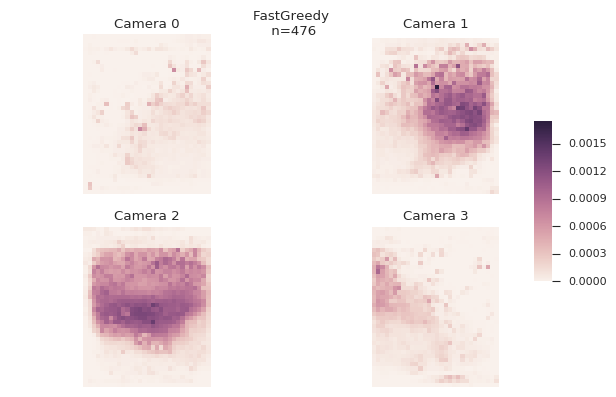

(38, 30)
(37, 30)
(39, 30)
(38, 30)


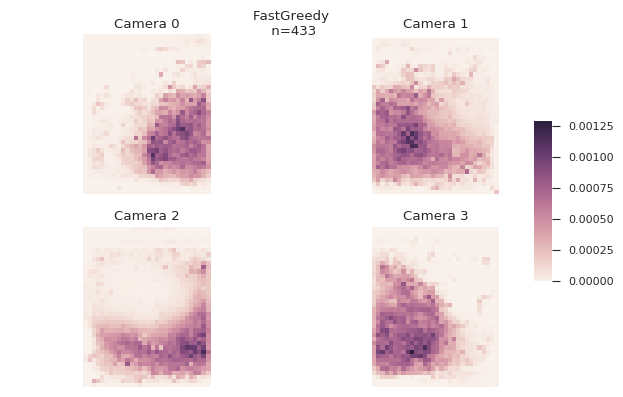

(38, 30)
(37, 30)
(39, 30)
(38, 30)


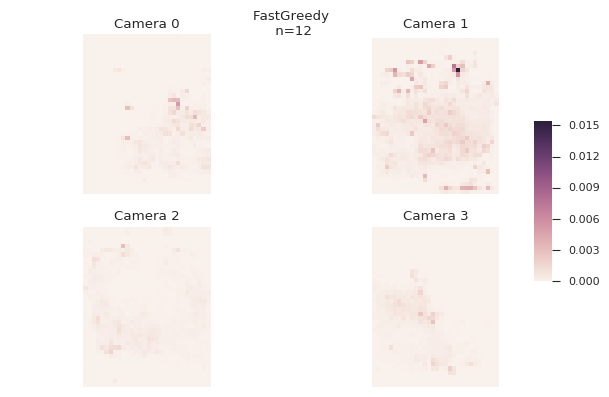

StopIteration: 

In [451]:
t3.groupby(by="community-fg").id.apply(list).apply(plotHeatmap, args=[30,40, "FastGreedy", "2016-08-20T08:00:00Z", "/mnt/data/2016_08_20_10h_8Uhr_95conf.db"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


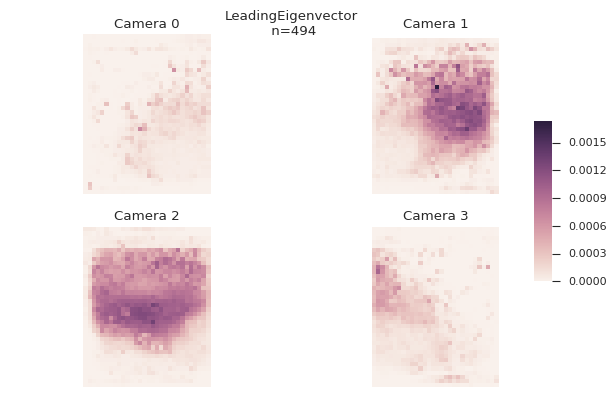

(38, 30)
(37, 30)
(39, 30)
(38, 30)


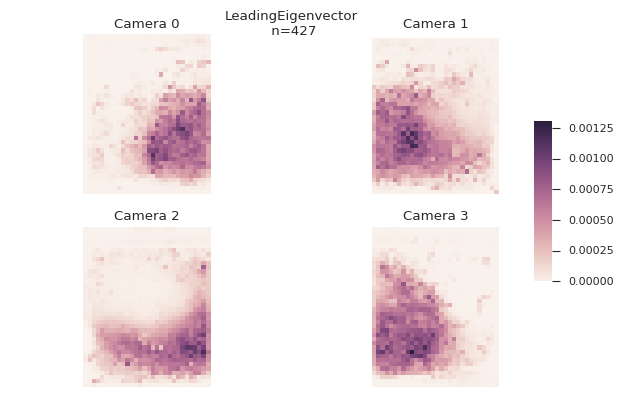

StopIteration: 

In [452]:
t3.groupby(by="community-le").id.apply(list).apply(plotHeatmap, args=[30,40, "LeadingEigenvector", "2016-08-20T08:00:00Z", "/mnt/data/2016_08_20_10h_8Uhr_95conf.db"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


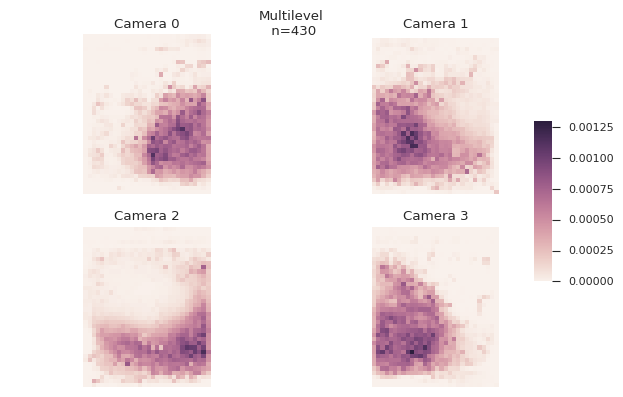

(38, 30)
(37, 30)
(39, 30)
(38, 30)


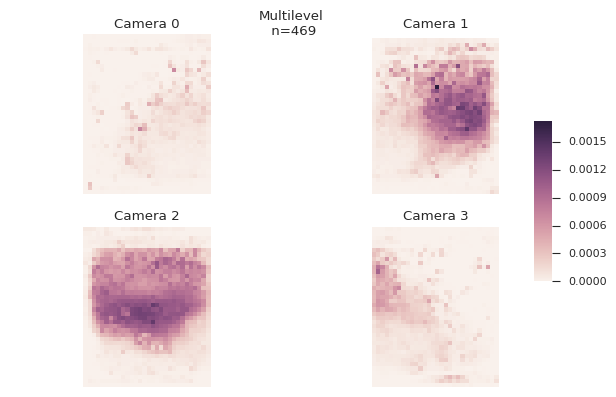

(38, 30)
(37, 30)
(39, 30)
(38, 30)


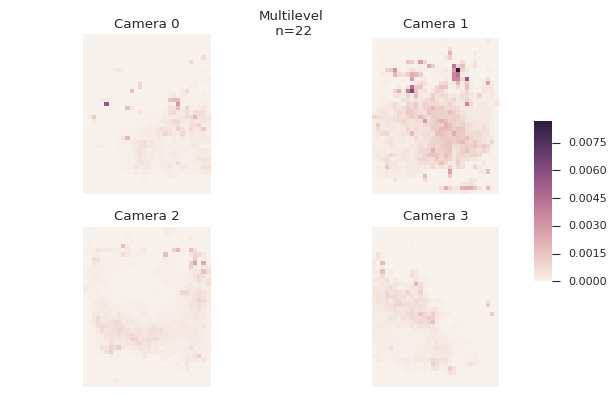

StopIteration: 

In [453]:
t3.groupby(by="community-ml").id.apply(list).apply(plotHeatmap, args=[30,40, "Multilevel", "2016-08-20T08:00:00Z", "/mnt/data/2016_08_20_10h_8Uhr_95conf.db"])

(38, 30)
(37, 30)
(39, 30)
(38, 30)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


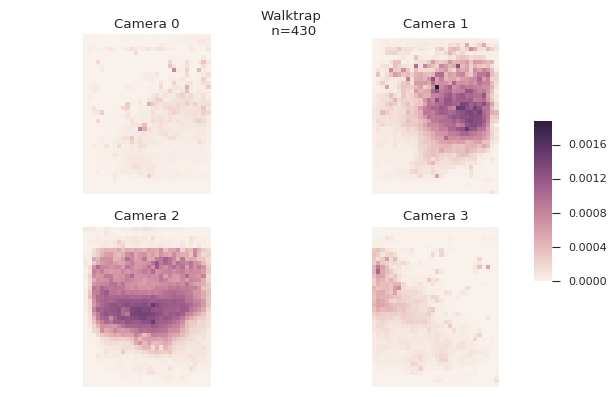

(38, 30)
(37, 30)
(39, 30)
(38, 30)


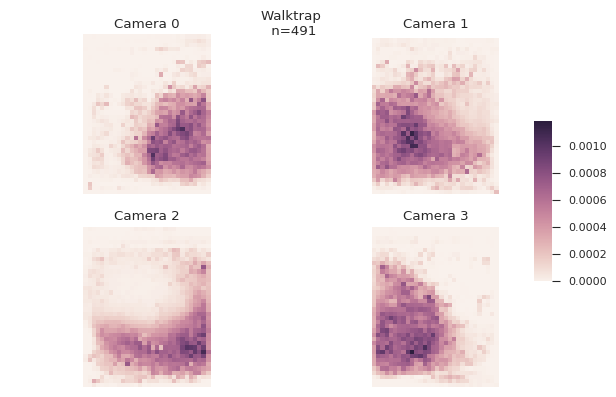

StopIteration: 

In [454]:
t3.groupby(by="community-wt").id.apply(list).apply(plotHeatmap, args=[30,40, "Walktrap", "2016-08-20T08:00:00Z", "/mnt/data/2016_08_20_10h_8Uhr_95conf.db"])

# Alter Testen

In [134]:
def kolmogorovStest(df, by):
    gr = df.groupby(by=by)
    for g1, gr1 in gr:
        for g2, gr2 in gr:
            if g1>=g2:
                continue
            print(g1, g2,stats.ks_2samp(df.age[df[by] == g1], df.age[df[by] == g2]))

In [133]:
def AgePerGroup(df, by):
    print("Total Mean: {}".format(df.age.mean()))
    
    df = df.query("age > -100 & age < 200")
    print("Mean after removal over very high and low: {}".format(df.age.mean()))

    df.age.hist(by=df[by], bins=15, range=(0,50))
    #plt.xlim([0,50])
    
    print("\nMean by community:")
    print(df.groupby(by=by).age.mean())

Total Mean: 17.59849119865884
Mean after removal over very high and low: 18.51735817104149

Mean by community:
community-le
0     7.640227
1    25.202811
2    20.063636
Name: age, dtype: float64


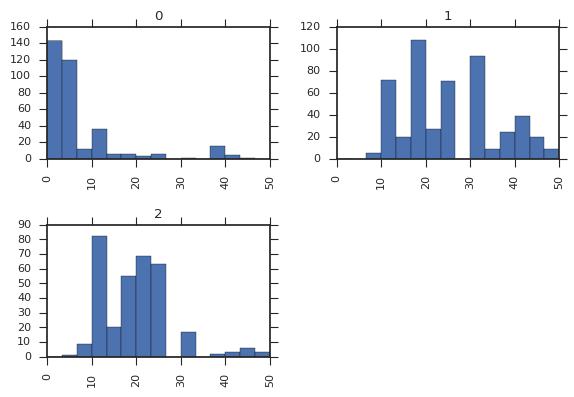

In [504]:
AgePerGroup(t1, "community-le")

Total Mean: 18.67214611872146
Mean after removal over very high and low: 19.572878228782287

Mean by community:
community-le
0    25.580286
1    11.268132
Name: age, dtype: float64


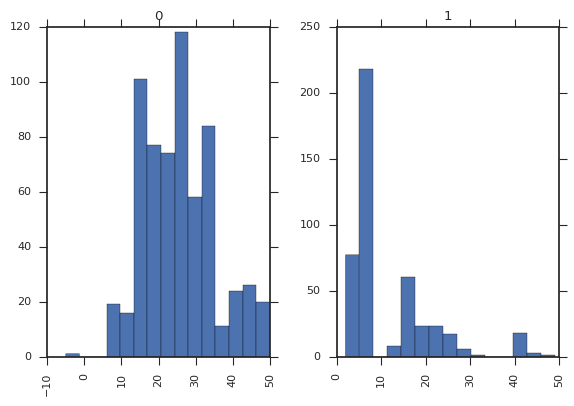

In [495]:
AgePerGroup(t2, "community-le")

Total Mean: 21.22234273318872
Mean after removal over very high and low: 22.456043956043956

Mean by community:
community-le
0    17.120930
1    27.235417
Name: age, dtype: float64


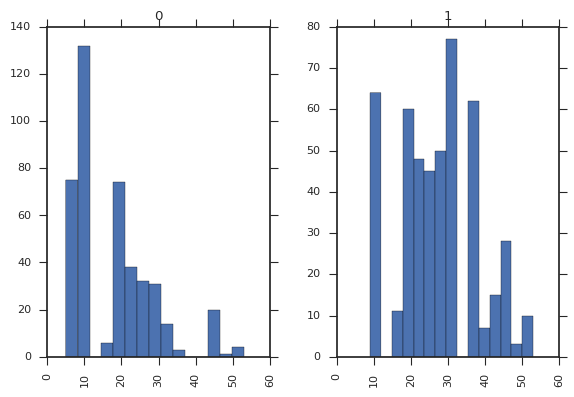

In [498]:
AgePerGroup(t3, "community-le")

In [505]:
for c in "fg le ml wt".split(' '):
    print(c)
    kolmogorovStest(t1, "community-{}".format(c))
    print("-")
    kolmogorovStest(t2, "community-{}".format(c))
    print("-")
    kolmogorovStest(t3, "community-{}".format(c))
    print('--------')

fg
0 1 Ks_2sampResult(statistic=0.74161172454793822, pvalue=3.0245900536061297e-122)
-
0 1 Ks_2sampResult(statistic=0.60158622285202001, pvalue=1.3405755169505602e-83)
0 2 Ks_2sampResult(statistic=0.19551475015051167, pvalue=0.16193675299285396)
1 2 Ks_2sampResult(statistic=0.612147677649861, pvalue=5.8973397682928205e-11)
-
0 1 Ks_2sampResult(statistic=0.38217184166171408, pvalue=1.2595954287086644e-29)
0 2 Ks_2sampResult(statistic=0.64531490015360982, pvalue=4.3503943010290671e-06)
1 2 Ks_2sampResult(statistic=0.26624383368569415, pvalue=0.21580271016451341)
--------
le
0 1 Ks_2sampResult(statistic=0.75691583946699081, pvalue=1.4208030535840771e-105)
0 2 Ks_2sampResult(statistic=0.72639105433452367, pvalue=4.1976143339943075e-81)
1 2 Ks_2sampResult(statistic=0.30645962145483341, pvalue=3.5892969696153827e-17)
-
0 1 Ks_2sampResult(statistic=0.59998146775389172, pvalue=6.3037273152748486e-85)
-
0 1 Ks_2sampResult(statistic=0.3946135831381733, pvalue=5.097938263750467e-32)
--------
ml
0

# Final - Community Stat

In [2]:
import os

In [10]:
# create DF with communities and age with leading eigenvector algo
def compareCommunities(g, datestr):
    
    lev = g.community_leading_eigenvector(weights="frequency")

    ids = []
    membership = lev.membership
    
    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))

    ids = DataFrame(ids, columns=["id", "community"])
    
    start_dt = datetime.datetime.strptime(datestr, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
    ids = addAge(ids, start_dt)

    return ids

In [3]:
graph_files = os.listdir("networks/")
graph_files = [g for g in graph_files if g.endswith('.graphml')]

In [23]:
graph_files.sort()

In [24]:
graph_files

['0813_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-13_08:00:00+00:00.graphml',
 '0814_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-14_08:00:00+00:00.graphml',
 '0816_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-16_08:00:00+00:00.graphml',
 '0817_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-17_08:00:00+00:00.graphml',
 '0820_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-20_08:00:00+00:00.graphml',
 '0822_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-22_08:00:00+00:00.graphml',
 '0824_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-24_08:00:00+00:00.graphml',
 '0825_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-25_08:00:00+00:00.graphml',
 '0902_10h_95conf_212dist_3ilen_2gap_600minutes_2016-09-02_08:00:00+00:00.graphml']

In [25]:
g_list = []
for f in graph_files:
    g_list.append((f,ig.Graph.Read_GraphML("networks/"+f)))

In [41]:
def getDFS(graph_liste):
    
    parts = np.empty(len(graph_liste), dtype=object)
    
    for e, (f, g) in enumerate(graph_liste):
        d = f.split("_")[-2]
        parts[e] = (d, compareCommunities(g, d))
    
    return parts

In [128]:
p = getDFS(g_list)

In [131]:
p[0][1].head()

,id,community,age
0,6,0,25
1,16,0,19
2,23,0,22
3,27,0,38
4,30,0,24


In [136]:
sns.set_context("paper")

In [123]:
def getDFSstat(p):
    
    d_ = []
    n_ = []
    ngroups_ = []
    sizes_ = []
    
    for elem in p:
        d = elem[0]
        df = elem[1]
        n = df.shape[0]
        ngroups = len(df.community.unique())
        sizes = df.groupby(by="community").size().apply(lambda x: x/n*100).iloc[:].values
        
        d_.append(d)
        n_.append(n)
        ngroups_.append(ngroups)
        sizes_.append(sizes)
    
    return DataFrame([d_, n_, ngroups_, sizes_], index=["date", "num_nodes", "num_comm", "comm"])

In [124]:
df = getDFSstat(p)

In [125]:
df = df.T

In [126]:
df

,date,num_nodes,num_comm,comm
0,2016-08-13,1243,2,"[54.1432019308, 45.8567980692]"
1,2016-08-14,1193,3,"[29.6730930427, 42.0787929589, 28.2481139983]"
2,2016-08-16,1167,3,"[18.4233076264, 41.2167952014, 40.3598971722]"
3,2016-08-17,1095,2,"[58.3561643836, 41.6438356164]"
4,2016-08-20,922,2,"[47.0715835141, 52.9284164859]"
5,2016-08-22,978,2,"[51.4314928425, 48.5685071575]"
6,2016-08-24,922,2,"[41.7570498915, 58.2429501085]"
7,2016-08-25,783,2,"[41.8901660281, 58.1098339719]"
8,2016-09-02,379,2,"[52.2427440633, 47.7572559367]"


In [294]:
def AgePerGroup2(df, by, txt):
    #print("Total Mean: {}".format(df.age.mean()))
    
    df = df.query("age > -100 & age < 200")
    print("Mean after removal over very high and low: {}".format(df.age.mean()))

    gr = list(df.groupby(by="community").age)
    gr = [b for a,b in gr]
    
    fig, ax = plt.subplots()
    plt.hist(gr, alpha=0.75, range=(0,60))
    plt.ylim((0,275))
    plt.tight_layout()
    plt.title("Age Distribution per Community\n {}".format(txt))
    plt.xlabel("Age in Days")
    plt.ylabel("Number of Bees")
    fig.set_size_inches(5.91553/2,3)
    plt.tight_layout()
    plt.savefig('confVSamount.pdf')
    
    #ax.set_title("B")
    #df.age.plot.hist(by=df[by], bins=10, range=(0,50), ylim=(0,275))
    #df.age.plot.box(by=df[by])
    
    print("\nMean by community:")
    print(df.groupby(by=by).age.mean())
    plt.show()

Mean after removal over very high and low: 17.392363931762794

Mean by community:
community
0    23.737952
1     9.961199
Name: age, dtype: float64


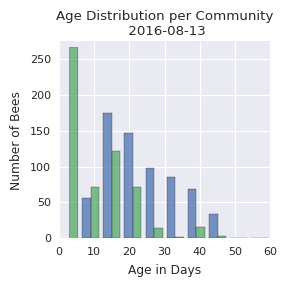

Mean after removal over very high and low: 18.51735817104149

Mean by community:
community
0     7.640227
1    25.202811
2    20.063636
Name: age, dtype: float64


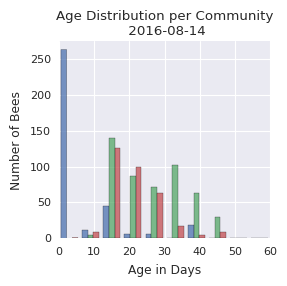

Mean after removal over very high and low: 18.8659169550173

Mean by community:
community
0    22.388626
1    10.221294
2    26.156652
Name: age, dtype: float64


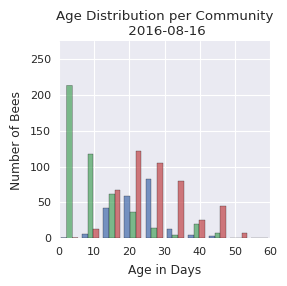

Mean after removal over very high and low: 19.572878228782287

Mean by community:
community
0    25.580286
1    11.268132
Name: age, dtype: float64


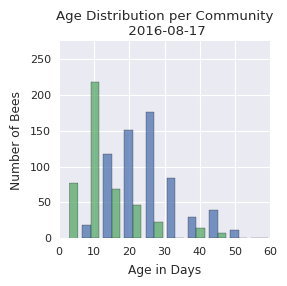

Mean after removal over very high and low: 22.456043956043956

Mean by community:
community
0    17.120930
1    27.235417
Name: age, dtype: float64


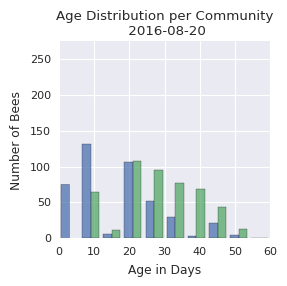

Mean after removal over very high and low: 21.77559462254395

Mean by community:
community
0    15.929719
1    27.982942
Name: age, dtype: float64


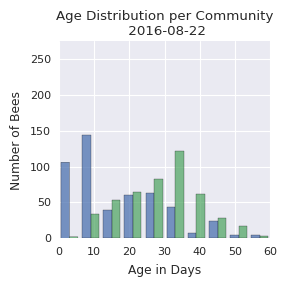

Mean after removal over very high and low: 22.205043859649123

Mean by community:
community
0    13.149606
1    28.702448
Name: age, dtype: float64


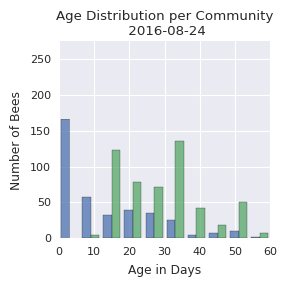

Mean after removal over very high and low: 21.970245795601553

Mean by community:
community
0    11.809231
1    29.341518
Name: age, dtype: float64


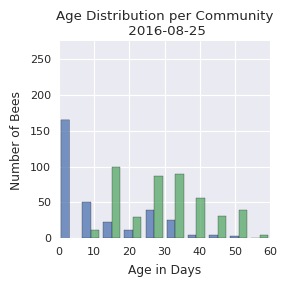

Mean after removal over very high and low: 27.146341463414632

Mean by community:
community
0    20.000000
1    35.068571
Name: age, dtype: float64


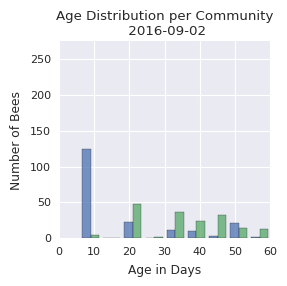

In [295]:
for elem in p:
    AgePerGroup2(elem[1], "community", elem[0])